# NeuroGym

NeuroGym is a comprehensive toolkit that allows training any network model on many established neuroscience tasks using Reinforcement Learning techniques. It includes working memory tasks, value-based decision tasks and context-dependent perceptual categorization tasks.

In this notebook we first show how to install the relevant toolbox. 

We then show how to access the available tasks and their relevant information.

Finally we train an LSTM network on the Random Dots Motion task using standard supervised learning techniques (with Keras), and plot the results.

### Installation

In [0]:
%tensorflow_version 1.x
# Install gym
! pip install gym
# Install neurogym
! git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
! pip install -e .

### Example

In [1]:
import warnings

import numpy as np
import neurogym as ngym

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Input

warnings.filterwarnings('ignore')
warnings.filterwarnings('default')

# Environment
task = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 100,
          'timing': {'fixation': ('constant', 200),
                     'stimulus': ('constant', 200),
                     'decision': ('constant', 200)}}
seq_len = 40

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len, cache_len=1e5)
env = dataset.env
obs_size = env.observation_space.shape[0]
act_size = env.action_space.n

# Model 
num_h = 64
# from https://www.tensorflow.org/guide/keras/rnn
xin = Input(batch_shape=(None, None, obs_size), dtype='float32')
seq = LSTM(num_h, return_sequences=True)(xin)
mlp = TimeDistributed(Dense(act_size, activation='softmax'))(seq)
model = Model(inputs=xin, outputs=mlp)
model.summary()
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train network
steps_per_epoch = 2000
data_generator = (dataset() for i in range(steps_per_epoch))
history = model.fit(data_generator, steps_per_epoch=steps_per_epoch)

ModuleNotFoundError: No module named 'tensorflow'

In [23]:
# TODO: Make this into a function in neurogym
perf = 0
num_trial = 200
for i in range(num_trial):
    env.new_trial()
    obs, gt = env.obs, env.gt
    obs = obs[np.newaxis]

    action_pred = model.predict(obs)
    action_pred = np.argmax(action_pred, axis=-1)
    perf += gt[-1] == action_pred[0, -1]

perf /= num_trial
print(perf)

0.765


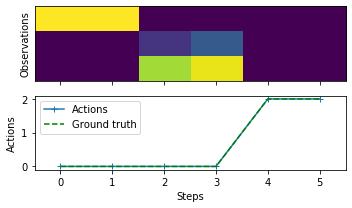

In [24]:
_ = ngym.utils.plotting.fig_(obs[0], action_pred[0], gt)